In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', 50)
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import numpy as np
import os
from tqdm.notebook import tqdm
from data_processing.utils.download_functions import *
from copy import deepcopy
os.chdir('esports-data')
os.listdir()

['2021_raw_game_data',
 '2022_raw_game_data',
 '2023_raw_game_data',
 'catboost_info',
 'leagues.json',
 'list.txt',
 'mapping_data.json',
 'players.json',
 'selected_features_RSV_Approx_200.txt',
 'teams.json',
 'tournaments.json']

In [2]:
# Read in teams data
with open("teams.json", "r") as json_file:
   teams_data = json.load(json_file)

team_df = []
for team in teams_data:
    team_df.append({'team_id': team['team_id'], 'team_name': team['name']})
    
team_df = pd.DataFrame(team_df)

In [6]:
# Get all file names from '2021_raw_game_data'
file_names = os.listdir('2021_raw_game_data')

# Get the unique tournament names by stripping out '_game_rows.csv' and '_tournament_rows.csv'
unique_tournament_names = [file_name.split('_game_rows.csv')[0] for file_name in file_names]
unique_tournament_names = [x.replace('_tournament_rows.csv', '') for x in unique_tournament_names]
unique_tournament_names = list(set(unique_tournament_names))

In [7]:
 # ['League_TFT Rising Legends', 'League_MSI', 'League_Worlds', 'League_All-Star Event'] 

In [8]:
# Aggregate all the game rows into one dataframe, start with an empty dataframe and append onto it to save memory
tournament_rows = pd.DataFrame()
for tournament_name in tqdm(unique_tournament_names):
    df_tmp = pd.read_csv('2021_raw_game_data/' + tournament_name + '_tournament_rows.csv')
    # Add a column to indicate the tournament name
    df_tmp['tournament_name'] = tournament_name
    df_tmp['year'] = '2021'
    tournament_rows = pd.concat([tournament_rows, df_tmp])

print("Tournament rows shape: ", tournament_rows.shape)

game_rows = pd.DataFrame()
for tournament_name in tqdm(unique_tournament_names):
    df_tmp = pd.read_csv('2021_raw_game_data/' + tournament_name + '_game_rows.csv', index_col=0)
    # Add a column to indicate the tournament name
    df_tmp['tournament_name'] = tournament_name
    game_rows = pd.concat([game_rows, df_tmp])
game_rows.shape

  0%|          | 0/51 [00:00<?, ?it/s]

Tournament rows shape:  (4990, 9)


  0%|          | 0/51 [00:00<?, ?it/s]

(9574, 1243)

In [9]:
non_game_features = ['platformGameId', 'esportsGameId', 'team_id', 'start_time', 'tournament_name']
league_indicators_to_drop = ['League_TFT Rising Legends', 'League_All-Star Event', 'League_MSI', 'League_Worlds', 'League_EMEA Masters']
league_indicators = [x for x in game_rows.columns if 'League_' in x]
league_indicators = [x for x in league_indicators if x not in league_indicators_to_drop]
game_rows = game_rows.drop(columns=league_indicators_to_drop, axis=1)


# Keep this if we want to analyze specific tournaments (e.g. MSI and Worlds) or if we want to upweight/downweight certain tournaments 
# game_rows = game_rows.drop(columns=['tournament_name'], axis=1)  

game_features = [x for x in game_rows.columns if x not in non_game_features + league_indicators + ['year']]
all_team_ids = np.unique(game_rows['team_id'])
print(len(all_team_ids))

240


In [10]:
"""
1. Sort the game_rows by team_id and start_time 
2. Create features for each team by averaging stats of the last 5 games that they played (or the most recent statistics if possible, with a "num_prev_games) column
    This yields a row of data where the features are the average of the last 5 games that the team played BEFORE the game of ['platformGameId', 'esportsGameId', 'team_id', 'start_time']
    We also need to drop the first row where we don't have any data to average over
3. Mark the last row of each team's data as the last game
    This is so that we can use this to predict the next game
3. Later join to the reg_season_games data for training the model 
4. Use the trained model to predict on the playoff_games data for testing 
"""

processed_game_data = []
for team in tqdm(all_team_ids):
    
    
    
    team_data = game_rows[game_rows['team_id']==team].reset_index()
    team_data = team_data.sort_values(by=['start_time'])
    team_data['num_prev_games'] = np.arange(len(team_data))
    # Create feature "outcome_domestic" which is the outcome if the team is playing in a domestic tournament (i.e., not worlds or msi), and otherwise NA
    # Create feature "outcome_international" which is the outcome if the team is playing in an international tournament (i.e., worlds or msi), and otherwise NA
    team_data['outcome_domestic'] = np.nan
    team_data['outcome_international'] = np.nan
    team_data.loc[team_data['tournament_name'].str.contains('worlds|msi'), 'outcome_international'] = team_data.loc[team_data['tournament_name'].str.contains('worlds|msi'), 'outcome']
    team_data.loc[~team_data['tournament_name'].str.contains('worlds|msi'), 'outcome_domestic'] = team_data.loc[~team_data['tournament_name'].str.contains('worlds|msi'), 'outcome']
    
    # First lag by 1 game so that the current game is not included in the average. Then take the mean as the trailing average 
    team_data_features = team_data[game_features].shift(1).rolling(window=20, min_periods=1).mean()
    team_data[game_features] = team_data_features
    # Drop rows where num_prev_games == 0 as this indicates that it's the team's first game 
    team_data = team_data[team_data['num_prev_games']!=0]
    # Add one more column to indicate if the row is the last of the team's games
    # last_game_indicator_col = pd.DataFrame({'last_game_ind': team_data['num_prev_games']==team_data['num_prev_games'].max()})
    # team_data = pd.concat([team_data, last_game_indicator_col], axis=1)

    # Get the team name 
    try:
        team_name = team_df[team_df['team_id']==str(team)]['team_name'].values[0]
    except IndexError:
        team_name = "NULL"
    # Add a column for the team name
    team_data['team_name'] = team_name
    # Determine the team's primary league
    team_league = team_data[league_indicators].mean(axis=0).idxmax()
    # Determine if it's a valid league (otherwise it'll just mark the first one)
    team_league_check = team_data[team_league].sum() > 0 # If false, then do not mark based on history, have to manually mark 
    
    # check if there are any rows where the team does not have a league_indicator (i.e., np.sum(team_data[league_indicators]) == 0) and if so, mark the team_league as 1 for those rows
    # This happens when a team plays in international tournaments 
    if team_league_check:
        team_data.loc[np.sum(team_data[league_indicators], axis=1)==0, team_league] = 1
    else:
        pass

    # update the processed_game_data with the new league_indicator values
    processed_game_data.append(team_data)

processed_game_data = pd.concat(processed_game_data)
processed_game_data.drop('index', axis=1, inplace=True)
print(len(processed_game_data))

  0%|          | 0/240 [00:00<?, ?it/s]

9334


In [14]:
team_data.iloc[1]

index                                     0
platformGameId        ESPORTSTMNT01:2571521
esportsGameId            107256578724179871
team_id                  107258254469504696
start_time          2021-12-03 09:11:06.834
                             ...           
League_Ultraliga                        0.0
League_VCS                              1.0
tournament_name             vcs_winter_2021
num_prev_games                            2
team_name                        Team Flash
Name: 8, Length: 1241, dtype: object

In [11]:
processed_game_data.iloc[0]

platformGameId        ESPORTSTMNT01:1690580
esportsGameId            105522984812784799
team_id                   98767991853197861
start_time          2021-01-13 11:56:00.361
outcome                                 1.0
                             ...           
League_Ultraliga                        0.0
League_VCS                              0.0
tournament_name             lck_spring_2021
num_prev_games                            1
team_name                                T1
Name: 64, Length: 1240, dtype: object

In [37]:
# Maintain a manual dictionary of team_id to league_indicator
# Loop through this and mark the league_indicator for each team_id as =1 for the rows where the team_id is present
league_indicator_dict = {
    '98767991954244555': 'League_VCS', # GAM
    '107251245690956393': 'League_VCS', # SAIGON BUFFALOS
    '98767991892579754': 'League_LPL',  # RNG
    '104367068120825486': 'League_PCS',  # PSG Talon
    '98767991882270868': 'League_LPL',  # EDG
    '99566404850008779': 'League_LPL',  # LNG
    '99566404855553726': 'League_LPL',  # FPX
    '99566404852189289': 'League_LPL',  # JDG
    '99566404854685458': 'League_LPL',  # TES
    '105520788833075738': 'League_Elite Series', # KV Mechelen
    '105520824521753126': 'League_NLC', # PSV Esports
    '105543843212923183': 'League_Ultraliga', # Goskilla
    '105548000936710641': 'League_Ultraliga', # Method2Madness
    '103935642731826448': 'League_Elite Series', # Sector One
    '104710682193583854': 'League_Ultraliga', # Topo Centras Iron Wolves
    '105520822049210915': 'League_Elite Series', # Team mCon
    '106334794714373670': 'League_Ultraliga', # Goexanimo
}

for team_id, league_indicator in league_indicator_dict.items():
    processed_game_data.loc[processed_game_data['team_id']==int(team_id), league_indicator] = 1

In [38]:
league_indicators

['League_Arabian League',
 'League_CBLOL',
 'League_CBLOL Academy',
 'League_College Championship',
 'League_Elite Series',
 'League_Esports Balkan League',
 'League_Greek Legends League',
 'League_Hitpoint Masters',
 'League_LCK',
 'League_LCK Academy',
 'League_LCK Challengers',
 'League_LCL',
 'League_LCO',
 'League_LCS',
 'League_LCS Challengers',
 'League_LCS Challengers Qualifiers',
 'League_LEC',
 'League_LJL',
 'League_LJL Academy',
 'League_LLA',
 'League_LPL',
 'League_La Ligue FranÃ§aise',
 'League_Liga Portuguesa',
 'League_NLC',
 'League_North Regional League',
 'League_PCS',
 'League_PG Nationals',
 'League_Prime League',
 'League_South Regional League',
 'League_SuperLiga',
 'League_TCL',
 'League_Ultraliga',
 'League_VCS']

In [39]:
# Create two additional features related to the esport league
# If the team is an LPL or LCK team, mark indicator 'eliteLeague' as 1
# If the team is an LEC, LCS, LPL, or LCK team, mark indicator 'majorLeague' as 1
processed_game_data['eliteLeague'] = (processed_game_data['League_LPL'] == 1) | (processed_game_data['League_LCK'] == 1)
processed_game_data['majorLeague'] = (processed_game_data['League_LPL'] == 1) | (processed_game_data['League_LCK'] == 1) | \
                                     (processed_game_data['League_LCS'] == 1) | (processed_game_data['League_LEC'] == 1)

In [40]:
processed_game_data[np.sum(processed_game_data[league_indicators], axis=1) > 1][['tournament_name']]

,tournament_name


In [41]:
# Check that the one-hot encoding worked correctly
if (np.sum(processed_game_data[league_indicators], axis=1) == 1).all():
    # Convert the league_indicator one-hot encoded columns to categorical variables
    for league in [x.replace('League_', '') for x in league_indicators]:
        processed_game_data['League_' + league] = processed_game_data['League_' + league].apply(lambda x: league if x==1 else '')
    # Combine it into a single column
    processed_game_data['eSportLeague'] = processed_game_data[league_indicators].apply(lambda x: ''.join(x), axis=1)
    processed_game_data = processed_game_data.drop(columns=league_indicators, axis=1)
    # Convert it to a categorical variable
    processed_game_data['eSportLeague'] = processed_game_data['eSportLeague'].astype('category')
else:
    raise ValueError('One-hot encoding of league_indicators did not work correctly')

In [42]:
valid_games = tournament_rows.merge(processed_game_data[['esportsGameId', 'team_id']], how='inner', 
                                    left_on=['esportsGameId', 'team_id_1'], 
                                    right_on=['esportsGameId', 'team_id'], 
                                    suffixes=['_to_drop','_to_drop'])
valid_games = valid_games.merge(processed_game_data[['esportsGameId', 'team_id']], how='inner', 
                                    left_on=['esportsGameId', 'team_id_2'], 
                                    right_on=['esportsGameId', 'team_id'],
                                    suffixes=['_to_drop','_to_drop'])
valid_games.drop([x for x in valid_games.columns if '_to_drop' in x], axis=1, inplace=True)

In [48]:
# Merge processed_game_data with tournament_rows for team 1
team_1_data = valid_games.merge(processed_game_data, how='inner', 
                                    left_on=['esportsGameId', 'team_id_1'], 
                                    right_on=['esportsGameId', 'team_id'],
                                    suffixes=['_to_drop','_to_drop'])

# Merge processed_game_data with tournament_rows for team 2
team_2_data = valid_games.merge(processed_game_data, how='inner', 
                                    left_on=['esportsGameId', 'team_id_2'], 
                                    right_on=['esportsGameId', 'team_id'],
                                    suffixes=['_to_drop','_to_drop'])

In [52]:
processed_game_data.iloc[0]

platformGameId      ESPORTSTMNT01:2690725
esportsGameId          107418445248214140
team_id                 98767991853197861
start_time        2022-01-12 12:14:30.937
outcome                               1.0
                           ...           
num_prev_games                          1
team_name                              T1
eliteLeague                          True
majorLeague                          True
eSportLeague                          LCK
Name: 16, Length: 1210, dtype: object

In [50]:
# Calculate the difference between the two teams for esportsGameId and for each feature
check_esportsGameId = np.all(team_1_data['esportsGameId'] == team_2_data['esportsGameId'])
check_team1_id = np.all(team_1_data['team_id_1'] == team_2_data['team_id_1'])
check_team2_id = np.all(team_1_data['team_id_2'] == team_2_data['team_id_2'])

if check_esportsGameId and check_team1_id and check_team2_id:
    # Calculate the difference between the two teams for each feature
    difference_data = team_1_data[game_features].subtract(team_2_data[game_features])
else:
    raise Exception('esportsGameId is not the same for the two teams')

# Add the difference data to the tournament_rows dataframe as well as the league data for each team
training_data = deepcopy(valid_games)
training_data = pd.concat([training_data.reset_index(), difference_data], axis=1)
training_data['eSportsLeague_1'] = team_1_data['eSportLeague']
training_data['eSportsLeague_2'] = team_2_data['eSportLeague']
training_data['eliteLeague_1'] = team_1_data['eliteLeague']
training_data['eliteLeague_2'] = team_2_data['eliteLeague']
training_data['majorLeague_1'] = team_1_data['majorLeague']
training_data['majorLeague_2'] = team_2_data['majorLeague']
training_data['start_time'] = team_1_data['start_time']
training_data['year'] = team_1_data['year'].astype('category')

# Drop the columns that were used for joining (have '_to_drop' suffix). 
training_data.drop([x for x in training_data.columns if '_to_drop' in x] + ['index'], axis=1, inplace=True)

# drop the games where the outcome is NaN, those games are when one team has not had any games yet
training_data.dropna(subset=['outcome'], inplace=True)

del team_1_data, team_2_data, difference_data

In [51]:
training_data.iloc[0]

match_id              107455808282869669
esportsGameId         107455808282869670
league                               LJL
team_id_1             101428372607057464
outcome_1                              0
                          ...           
eliteLeague_1                      False
eliteLeague_2                      False
majorLeague_1                      False
majorLeague_2                      False
start_time       2022-02-20 12:01:25.245
Name: 0, Length: 1216, dtype: object

In [60]:
# Do catboost on the training data
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import GridSearchCV

target_col = 'outcome_1'
## At this point could assign row weights based on 'tournament_name' column to upweight/downweight certain tournaments
X = training_data.drop(['match_id', 'esportsGameId', 'league', 'team_id_1', 'outcome_1', 'team_id_2', 'outcome_2'], axis=1)
y = training_data[target_col]

# Split into train/val/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=20)

# Get all indices where X_train['tournment_name'] contains ['worlds', 'msi'] 
international_ix_train = X_train['tournament_name'].str.contains('worlds|msi')
international_ix_test = X_test['tournament_name'].str.contains('worlds|msi')

# Create a weight vector where the international games are weighted 2x
weights_train = np.ones(len(X_train))
weights_train[international_ix_train] = 10

X_train = X_train.drop('tournament_name', axis=1)
train_data = Pool(data=X_train, label=y_train, weight=weights_train, cat_features=['eSportsLeague_1', 'eSportsLeague_2'])
X_val = X_val.drop('tournament_name', axis=1)
X_test = X_test.drop('tournament_name', axis=1)

In [61]:
X_train.iloc[0]

year                          2021
outcome                        0.6
first_riftHerald_ind      0.016667
first_riftHerald_time   -39.869654
num_riftHerald                 0.2
                           ...    
eSportsLeague_2                LLA
eliteLeague_1                False
eliteLeague_2                False
majorLeague_1                False
majorLeague_2                False
Name: 1773, Length: 1207, dtype: object

In [23]:
# Hyperparameter tuning

import optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_categorical("iterations", [10, 15, 25, 50, 100, 200]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 30),
        "random_strength": trial.suggest_categorical("random_strength", [0.5, 1, 1.5, 2])
    }

    model = CatBoostClassifier(**params, cat_features=['eSportsLeague_1', 'eSportsLeague_2'], task_type="GPU", devices='0:1', silent=True)
    model.fit(train_data)
    predictions = model.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2023-09-29 22:20:21,085] A new study created in memory with name: no-name-18cfb155-783d-4a3a-951b-e6e3c59290fe
[I 2023-09-29 22:20:33,018] Trial 0 finished with value: 0.6 and parameters: {'iterations': 100, 'learning_rate': 0.13523003311340323, 'depth': 9, 'min_data_in_leaf': 70, 'l2_leaf_reg': 18, 'random_strength': 1.5}. Best is trial 0 with value: 0.6.
[I 2023-09-29 22:20:33,860] Trial 1 finished with value: 0.6245283018867924 and parameters: {'iterations': 10, 'learning_rate': 0.0032547565073251733, 'depth': 5, 'min_data_in_leaf': 56, 'l2_leaf_reg': 19, 'random_strength': 1.5}. Best is trial 1 with value: 0.6245283018867924.
[I 2023-09-29 22:20:34,775] Trial 2 finished with value: 0.6132075471698113 and parameters: {'iterations': 25, 'learning_rate': 0.06218428331384312, 'depth': 3, 'min_data_in_leaf': 85, 'l2_leaf_reg': 29, 'random_strength': 0.5}. Best is trial 1 with value: 0.6245283018867924.
[I 2023-09-29 22:20:41,674] Trial 3 finished with value: 0.6113207547169811 and pa

In [24]:
# Print the best parameters and fit a new model on the data based on it
print(study.best_params)
model = CatBoostClassifier(**study.best_params, cat_features=['eSportsLeague_1', 'eSportsLeague_2'], task_type="GPU", devices='0:1', silent=True)
model.fit(X_train, y_train)

{'iterations': 25, 'learning_rate': 0.01512027005140927, 'depth': 5, 'min_data_in_leaf': 36, 'l2_leaf_reg': 19, 'random_strength': 1.5}


In [25]:
yhat_train_model = np.round(model.predict(X_train))
yhat_train_base = (X_train['outcome'] >= 0)

yhat_test_model = np.round(model.predict(X_test))
yhat_test_base = (X_test['outcome'] >= 0)

In [26]:
 # TRAINING DATA
print("TRAINING DATA")
# Evaluate the accuracy overall, for international games, and for domestic games separately
print(f"Accuracy overall: {accuracy_score(y_train, yhat_train_model)}")
print(f"Accuracy international: {accuracy_score(y_train[international_ix_train], yhat_train_model[international_ix_train])}")
print(f"Accuracy domestic: {accuracy_score(y_train[~international_ix_train], yhat_train_model[~international_ix_train])}")

print()

# Evaluate the accuracy for the baseline
print(f"Baseline accuracy overall: {accuracy_score(y_train, yhat_train_base)}")
print(f"Baseline accuracy international: {accuracy_score(y_train[international_ix_train], yhat_train_base[international_ix_train])}")
print(f"Baseline accuracy domestic: {accuracy_score(y_train[~international_ix_train], yhat_train_base[~international_ix_train])}")

# TESTING DATA 
print("\n TESTING DATA")
# Evaluate the accuracy overall, for international games, and for domestic games separately
print(f"Accuracy overall: {accuracy_score(y_test, yhat_test_model)}")
print(f"Accuracy international: {accuracy_score(y_test[international_ix_test], yhat_test_model[international_ix_test])}")
print(f"Accuracy domestic: {accuracy_score(y_test[~international_ix_test], yhat_test_model[~international_ix_test])}")

print()

# Evaluate the accuracy for the baseline 
print(f"Baseline accuracy overall: {accuracy_score(y_test, yhat_test_base)}")
print(f"Baseline accuracy international: {accuracy_score(y_test[international_ix_test], yhat_test_base[international_ix_test])}")
print(f"Baseline accuracy domestic: {accuracy_score(y_test[~international_ix_test], yhat_test_base[~international_ix_test])}")

TRAINING DATA
Accuracy overall: 0.6616288832913518
Accuracy international: 0.5714285714285714
Accuracy domestic: 0.6627017841971113

Baseline accuracy overall: 0.6274139378673383
Baseline accuracy international: 0.5
Baseline accuracy domestic: 0.62892948173322

 TESTING DATA
Accuracy overall: 0.6525679758308157
Accuracy international: 0.5625
Accuracy domestic: 0.6536697247706422

Baseline accuracy overall: 0.6465256797583081
Baseline accuracy international: 0.6875
Baseline accuracy domestic: 0.6460244648318043


In [27]:
# Check the feature importance of the model
pd.DataFrame({x: y for x, y in zip(X_train.columns, model.get_feature_importance())}, index = [0]).T.sort_values(by=0, ascending=False)

,0
team_share_of_towerKills_at_game_end,14.419113
team_share_of_totalGold_at_game_end,9.207683
bot_gold_per_min_diff_at_game_end,6.112707
bot_damage_to_buildings_per_min_diff_at_game_end,5.035371
outcome,4.784940
...,...
mid_share_of_team_gold_at_14,0.000000
jungle_share_of_team_gold_at_14,0.000000
top_share_of_team_gold_at_14,0.000000
support_share_of_minions_stolen_at_14,0.000000


In [28]:
# Get shapley values for the first prediction just to test the functionality 
import shap
shap.initjs()

In [29]:
import fasttreeshap
shap_explainer = fasttreeshap.TreeExplainer(model, algorithm = "v1", n_jobs = -1)
shap_values = shap_explainer(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


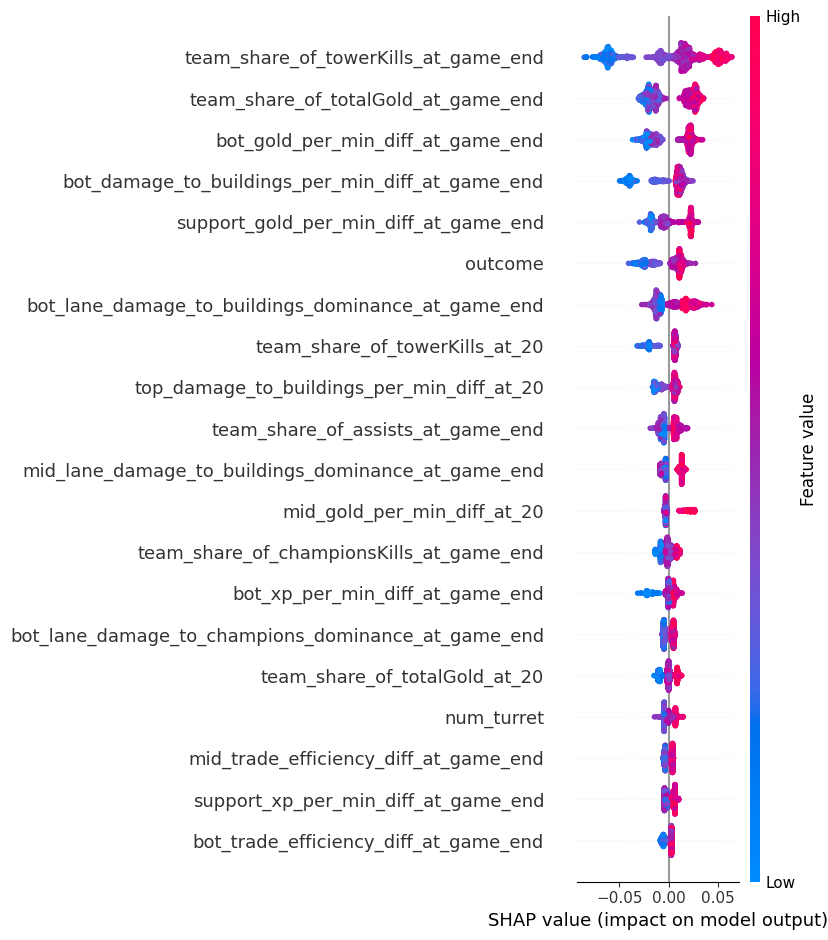

In [30]:
shap.summary_plot(shap_values, X_test)

In [73]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


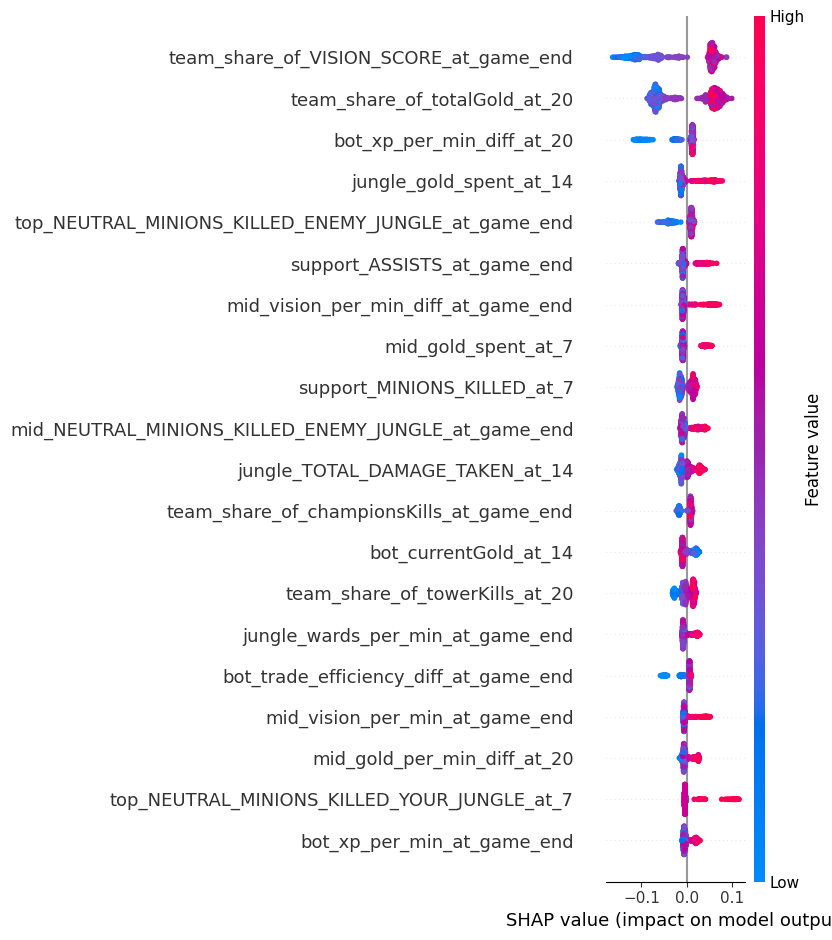

In [74]:
shap.summary_plot(shap_values, X_test)

In [19]:
# LPL has issues in Worlds and MSI because they don't show up in the data until 2023. We have to manually detect and relabel them.
# Do this by filtering to rows where tournament name is MSI or Worlds, and get teams where the sum of the league indicators is 0 (i.e. they haven't played anywhere prior)
LPL_teams = []


# 'european_masters_spring_2021_play_ins'
# 'european_masters_summer_2021_play_ins'
league_colnames = [x for x in processed_game_data.columns if 'League' in x]
msi_rows = processed_game_data[processed_game_data['tournament_name']=='european_masters_summer_2021_play_ins'][non_game_features + league_indicators]
# Filter msi_rows to instances where the sum of league_indicators is NOT 1
msi_rows = msi_rows[msi_rows[league_indicators].sum(axis=1) != 1]
msi_rows['team_id'] = msi_rows['team_id'].astype('str')
# join msi rows with the team_name
msi_rows = msi_rows.merge(team_df, on='team_id', how='left')
# msi_rows[msi_rows[league_indicators].sum(axis=1) == 1][['team_id', 'team_name']]
msi_rows[['team_id', 'team_name'] + league_indicators]

,team_id,team_name,League_Arabian League,League_CBLOL,League_CBLOL Academy,League_College Championship,League_Elite Series,League_Esports Balkan League,League_Greek Legends League,League_Hitpoint Masters,League_LCK,League_LCK Academy,League_LCK Challengers,League_LCL,League_LCO,League_LCS,League_LCS Challengers,League_LCS Challengers Qualifiers,League_LEC,League_LJL,League_LJL Academy,League_LLA,League_LPL,League_La Ligue FranÃ§aise,League_Liga Portuguesa,League_NLC,League_North Regional League,League_PCS,League_PG Nationals,League_Prime League,League_South Regional League,League_SuperLiga,League_TCL,League_Ultraliga,League_VCS
0,103935642731826448,Sector One,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,103935642731826448,Sector One,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,103935642731826448,Sector One,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,103935642731826448,Sector One,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,103935642731826448,Sector One,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,103935642731826448,Sector One,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,104710682193583854,Topo Centras Iron Wolves,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,104710682193583854,Topo Centras Iron Wolves,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,104710682193583854,Topo Centras Iron Wolves,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,104710682193583854,Topo Centras Iron Wolves,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
league_indicator_dict = {
    '98767991954244555': 'League_VCS', # GAM
    '107251245690956393': 'League_VCS', # SAIGON BUFFALOS
    '98767991892579754': 'League_LPL',  # RNG
    '104367068120825486': 'League_PCS',  # PSG Talon
    '98767991882270868': 'League_LPL',  # EDG
    '99566404850008779': 'League_LPL',  # LNG
    '99566404855553726': 'League_LPL',  # FPX
    '99566404852189289': 'League_LPL',  # JDG
    '99566404854685458': 'League_LPL',  # TES
    '105520788833075738': 'League_Elite Series', # KV Mechelen
    '105520824521753126': 'League_Elite Series', # PSV Esports
    '105543843212923183': 'League_Elite Series', # Goskilla
    '105548000936710641': 'League_Elite Series', # Method2Madness
    '103935642731826448': 'League_Elite Series', # Sector One
    '104710682193583854': 'League_Elite Series', # Topo Centras Iron Wolves
    '105520822049210915': 'League_Elite Series', # Team mCon
    '106334794714373670': 'League_Elite Series', # Goexanimo
}